## 3. Implementando os Simuladores para o Caso Exponencial

Cenário $\lambda = 1$ e $\mu  = 2$

Descrição: Considere uma fila M/M/1, em que chegadas ocorrem segundo um fluxo Poisson com taxa 1 chegadas/segundo e serviços são tais que cada serviço é distribuído exponencialmente com média 1/2 segundo. Implemente dois simuladores.

In [41]:
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [68]:
def simulate1(arrival_rate, service_rate, max_steps=1000):
    total_arrivals = total_departures = total_waiting_time = simulation_time = queue_length = 0
    arrivals_queue = []

    for i in range(max_steps):
        sample_arrival = random.expovariate(arrival_rate)
        sample_departure = random.expovariate(service_rate)

        if queue_length == 0 or sample_arrival < sample_departure:
            # Arrival
            simulation_time += sample_arrival
            total_arrivals += 1
            queue_length += 1
            if queue_length > 1:
                arrivals_queue.append(simulation_time)
        else:
            # Departure
            simulation_time += sample_departure
            total_departures += 1
            queue_length -= 1
            if len(arrivals_queue) > 0:
                total_waiting_time += simulation_time - arrivals_queue.pop(0)

    average_waiting_time = total_waiting_time / total_departures
    average_clients_in_system = total_arrivals / simulation_time

    return {
        "average_waiting_time": average_waiting_time,
        "average_clients_in_system": average_clients_in_system
    }

In [69]:
simulate1(1, 2, 1000)

{'average_waiting_time': 0.46748039352110476,
 'average_clients_in_system': 1.0106840002140698}

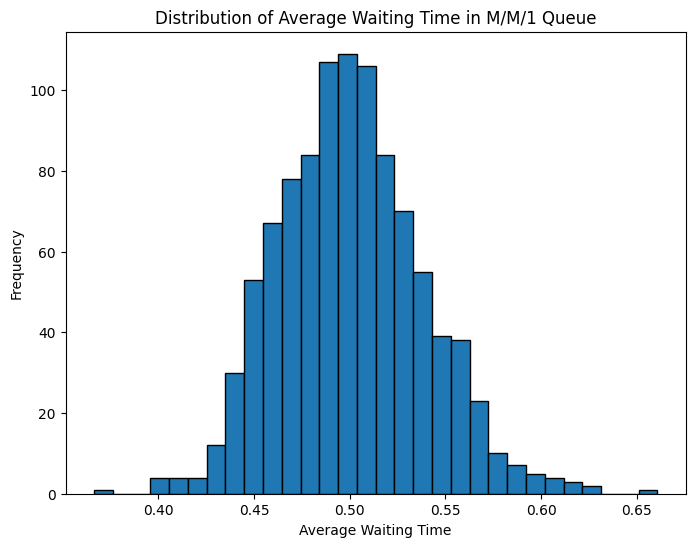

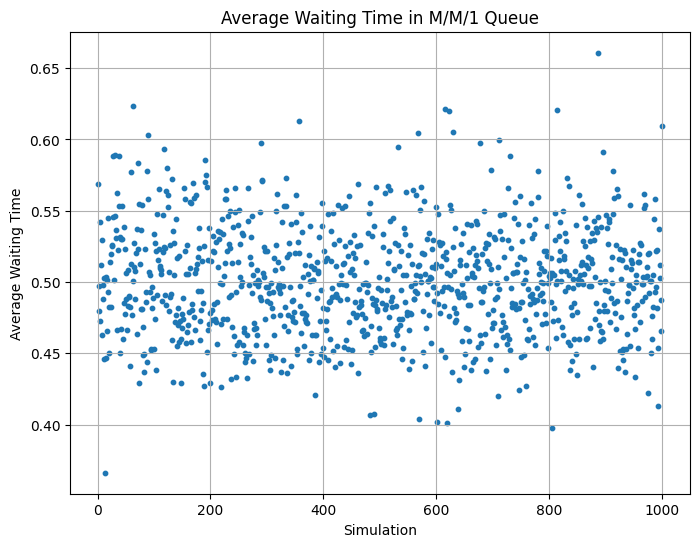

In [38]:
n_simulations = 1000
average_waiting_times = [simulate1(1, 2, 10000)["average_waiting_time"] for _ in range(n_simulations)]

# Plotting
plt.figure(figsize=(8, 6))
plt.hist(average_waiting_times, bins=30, edgecolor='black')
plt.xlabel('Average Waiting Time')
plt.ylabel('Frequency')
plt.title('Distribution of Average Waiting Time in M/M/1 Queue')

plt.figure(figsize=(8, 6))
plt.scatter(range(1, n_simulations + 1), average_waiting_times, s=10)
plt.xlabel('Simulation')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time in M/M/1 Queue')

plt.grid(True)
plt.show()

In [64]:
def update(frame, arrival_rate, service_rate, max_steps, ax, scat):
    # ax.cla()  # Clear current plot

    max_steps = frame + 1  # Increment max_steps for each frame
    average_waiting_times = [simulate1(arrival_rate, service_rate, max_steps)["average_waiting_time"] for _ in range(n_simulations)]

    scat.set_offsets(list(zip(range(1, num_simulations + 1), average_waiting_times)))
    ax.xlabel('Simulation')
    ax.ylabel('Average Waiting Time')
    ax.title(f'Average Waiting Time in M/M/1 Queue (Max Steps: {max_steps})')
    plt.grid(True)

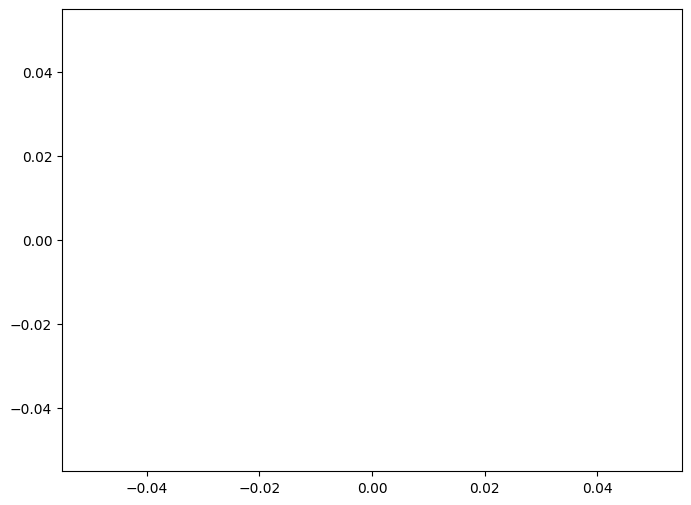

In [65]:
# Simulation parameters
num_simulations = 100
max_frames = 40
max_steps = 1000
arrival_rate = 1  # (lambda)
service_rate = 2  # (mu)

# Create animation
fig, ax = plt.subplots(figsize=(8, 6))
scat = ax.scatter([], [], s=10)

animation = FuncAnimation(fig, update, fargs=(arrival_rate, service_rate, max_steps, ax, scat))
plt.show()